# MOS score prediction from wav2vec2 embeddings

* calculate wav2vec2 embeddings for test and train datasets
* create MOSDataset, containing wav2vec2 embeddings and subjective MOS scores
* define a simple neural network to predict MOS scores from wav2vec2 embeddings
* train the neural network and save the model
* evaluate the model
* repeat the process for different wav2vec2 models? other embeddings? use embeddings from different layers? need another 8 months to finish this notebook

In [1]:
import os
from tqdm.auto import tqdm
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt


# wav2vec
from transformers import Wav2Vec2FeatureExtractor, Wav2Vec2Model, Wav2Vec2Config
import librosa

# torch
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchsummary import summary
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')


/home/aleph/tesis/.env/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# wav2vec2 embeddings extraction

In [2]:
def wav2vec_embeddings(path_to_csv, model_name, output_dir):
    """Extracts embeddings from audio files given a specific Wav2Vec2 model.
    Extracts all layers and stacks them together into a tensor. Then saves that tensor as a numpy array.
    Expects csv file with a column named "stimuli" containing paths to audio files."""

    os.makedirs(output_dir, exist_ok=True)

    config = Wav2Vec2Config.from_pretrained(model_name, output_hidden_states=True)
    feature_extractor = Wav2Vec2FeatureExtractor.from_pretrained(model_name)
    model = Wav2Vec2Model(config)
    
    #load data
    metadata_df = pd.read_csv(path_to_csv)

    # iterate over each path in "stimuli" column
    for _, row in tqdm(metadata_df.iterrows()):
        audio_file = row['stimuli']
        input_audio, sample_rate = librosa.load(audio_file, sr=16000)
        inputs = feature_extractor(input_audio, return_tensors="pt", sampling_rate=sample_rate)
        
        with torch.no_grad():
            outputs= model(**inputs)
        
        all_layer_embeddings = outputs.hidden_states

        # Concatenate hidden states from all layers and take the mean across the sequence
        # Skip the first layer --> output of the CNN layers with an added positional embedding
        embeddings = torch.cat(all_layer_embeddings[, dim=0)
        embeddings = embeddings.mean(dim=1)

        # Save embeddings as numpy array
        embeddings = embeddings.squeeze().detach().numpy()
        file_name = os.path.basename(audio_file).split('.')[0]

        np.save(os.path.join(output_dir, f"{file_name}.npy"), embeddings)

In [9]:
# extract embeddings for dev set
path_to_dev_csv = '/home/aleph/tesis/classifier/dev.csv'
path_to_dev_embeddings = '/home/aleph/tesis/classifier/embeddings/dev'
# wav2vec_embeddings(path_to_dev_csv, path_to_dev_embeddings)

# extract embeddings for test set
path_to_test_csv = '/home/aleph/tesis/classifier/test.csv'
path_to_test_embeddings = '/home/aleph/tesis/classifier/embeddings/test'
# wav2vec_embeddings(path_to_test_csv, path_to_test_embeddings)

# extract embeddings for train set
path_to_train_csv = '/home/aleph/tesis/classifier/train.csv'
path_to_train_embeddings = '/home/aleph/tesis/classifier/embeddings/train'
# wav2vec_embeddings(path_to_train_csv, path_to_train_embeddings)

OSError: facebook/wav2vec2-base-960h does not appear to have a file named config.json. Checkout 'https://huggingface.co/facebook/wav2vec2-base-960h/tree/main' for available files.

## attempt to plot some sort of distribution of the embeddings

In [12]:
# let's explore the embeddings to see distributions of data
import matplotlib.pyplot as plt
import seaborn as sns
from numpy import array
from numpy import float32

# get the embeddings read from the csv
train_embeddings = pd.read_csv(path_to_save_train_embeddings)
test_embeddings = pd.read_csv(path_to_save_test_embeddings)

# get the embeddings
train_embeddings = train_embeddings['embeddings']
test_embeddings = test_embeddings['embeddings']

# convert the strings to lists
train_embeddings = train_embeddings.apply(lambda x: eval(x))
test_embeddings = test_embeddings.apply(lambda x: eval(x))

# convert the lists to numpy arrays
train_embeddings = np.array(train_embeddings.tolist())
test_embeddings = np.array(test_embeddings.tolist())

# get the shape of the embeddings
print(f"Train embeddings shape: {train_embeddings.shape}")
print(f"Test embeddings shape: {test_embeddings.shape}")




Train embeddings shape: (3473, 1, 768)
Test embeddings shape: (863, 1, 768)


In [38]:
import umap.umap_ as umap

#Create a numpy array with the features and project them to 2D using UMAP:
X = np.stack(train_embeddings.squeeze())
print('Projecting to 2D with UMAP')
projector = umap.UMAP()
projected = projector.fit_transform(X)
metadata_df = pd.DataFrame()
metadata_df['X'] = projected[:,0]
metadata_df['Y'] = projected[:,1]

Projecting to 2D with UMAP


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


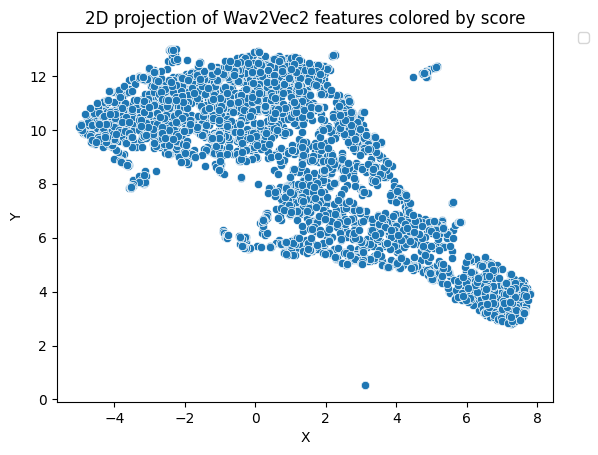

In [40]:
plt.title('2D projection of Wav2Vec2 features colored by score')
sns.scatterplot(data=metadata_df,x='X',y='Y')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0)

Projecting to 2D with UMAP


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


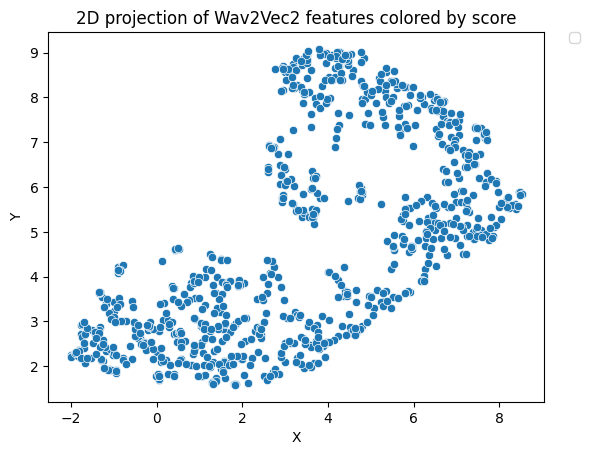

In [41]:
import umap.umap_ as umap

#Create a numpy array with the features and project them to 2D using UMAP:
X = np.stack(test_embeddings.squeeze())
print('Projecting to 2D with UMAP')
projector = umap.UMAP()
projected = projector.fit_transform(X)
metadata_df = pd.DataFrame()
metadata_df['X'] = projected[:,0]
metadata_df['Y'] = projected[:,1]

plt.title('2D projection of Wav2Vec2 features colored by score')
sns.scatterplot(data=metadata_df,x='X',y='Y')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0)

# MOSDataset
* Convert the embeddings from string representations into proper tensors.
* Separate the data into features (embeddings) and targets (MOS scores).

In [2]:
# Custom dataset to read embeddings and MOS scores from a CSV
from numpy import array
from numpy import float32

class MOSDataset(Dataset):
    def __init__(self, csv_file, split):
        # Load the CSV file
        self.data = pd.read_csv(csv_file)
        self.split = split  # Store the split (train, val, test)

        
    def __len__(self):
        return len(self.data)  # Total number of samples in the dataset
    
    def __getitem__(self, idx):
        # Get the embeddings and MOS scores for the given index
        file_name = os.path.basename(self.data.iloc[idx]['stimuli'])
        file_folder = os.path.basename(os.path.dirname(self.data.iloc[idx]['stimuli']))

        embeddings_path = f"/home/aleph/tesis/classifier/embeddings/{self.split}/{file_folder}/{file_name.split('.')[0]}.npy"

        # Check if the embeddings file exists
        if not os.path.isfile(embeddings_path):
            raise FileNotFoundError(f"Embeddings file not found at {embeddings_path}")

        embeddings = np.load(embeddings_path)

        mos_score = self.data.iloc[idx]['mos_average']

        # Convert the numpy array of embeddings to a tensor
        embeddings_tensor = torch.tensor(embeddings, dtype=torch.float32)  # Convert to PyTorch tensor

        # drop first layer
        # embeddings_tensor = embeddings_tensor[1:]
                
        # MOS score should be a single value
        mos_tensor = torch.tensor([mos_score], dtype=torch.float32)  # Convert to tensor
        
        return embeddings_tensor, mos_tensor

# Create the training DataLoader
train_csv_path = "/home/aleph/tesis/classifier/train_average.csv"
train_dataset = MOSDataset(train_csv_path, split='train')
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True, num_workers=2)  # DataLoader with batching and shuffling

# Create the validation DataLoader
val_csv_path = "/home/aleph/tesis/classifier/val_average.csv"
val_dataset = MOSDataset(val_csv_path, split='val')
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False, num_workers=2)

# Create the testing DataLoader
test_csv_path = "/home/aleph/tesis/classifier/test_average.csv"
test_dataset = MOSDataset(test_csv_path, split='test')
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False, num_workers=2) 


In [3]:
# Test getting an item
try:
    embeddings, mos = test_dataset[0]  # Test the first item
    print("Embeddings shape:", embeddings.shape)  # Expected shape
    print("MOS score:", mos.item())  # Expected MOS score
except Exception as e:
    print("Error getting item:", e)

Embeddings shape: torch.Size([13, 768])
MOS score: 1.5


In [4]:
#print length of the datasets
print(f"Train dataset length: {len(train_dataset)}")
print(f"Validation dataset length: {len(val_dataset)}")
print(f"Test dataset length: {len(test_dataset)}")

Train dataset length: 3136
Validation dataset length: 313
Test dataset length: 307


# Neural network

In [15]:
class WeightedAverage(torch.nn.Module):
    def __init__(self, num_layers=12):
        super().__init__()
        self.weights = torch.nn.Parameter(data=torch.ones((num_layers,)))
       
    def forward(self, x):
        w = torch.nn.functional.softmax(self.weights, dim=0)
        x_weighted = x*w[None,:,None]
        return torch.sum(x_weighted, dim=1)

class DenseMOS(nn.Module):
    def __init__(self, input_dim, hidden_dim, dropout_prob, num_layers):
        super(DenseMOS, self).__init__()

        # add a weighted average layer
        self.weighted_average = WeightedAverage(num_layers)
        
        # First dense layer with 128 neurons, ReLU activation, and dropout
        self.layer1 = nn.Sequential(
            nn.Linear(input_dim, hidden_dim),  # Linear layer for dense transformation
            nn.ReLU(),  # ReLU activation
            nn.Dropout(dropout_prob),  # Dropout with 0.2
        )

        # Second dense layer, same design
        self.layer2 = nn.Sequential(
            nn.Linear(hidden_dim, hidden_dim),
            nn.ReLU(),
            nn.Dropout(dropout_prob),
        )

        # Final dense layer for MOS score prediction
        self.output_layer = nn.Linear(hidden_dim, 1)  # Linear layer to predict MOS

    def forward(self, x):
        # Apply the weighted average to combine 12 layers into 1
        x = self.weighted_average(x)  # Apply WeightedAverage

        # Pass the input through the first dense layer
        x = self.layer1(x)

        # Pass through the second dense layer
        x = self.layer2(x)

        # Pass through the final dense layer to get the MOS score
        x = self.output_layer(x)  # Output layer

        # # Constrain the output to the 1-5 range
        # x = torch.sigmoid(x)  # Constrain between 0 and 1
        # x = 1 + 4 * x  # Scale to 1-5

        return x


# Define the model parameters
input_dim = 768  # Single 768-dimensional input
hidden_dim = 128  # Hidden dimension for dense layers
dropout_prob = 0.6  # Dropout probability
num_layers = 13  # Number of layers in the Wav2Vec2 model

# Training

In [16]:
# Instantiate the DenseMOS model
dense_mos = DenseMOS(input_dim, hidden_dim, dropout_prob, num_layers)
dense_mos.to(device)  # Move the model to the device

DenseMOS(
  (weighted_average): WeightedAverage()
  (layer1): Sequential(
    (0): Linear(in_features=768, out_features=128, bias=True)
    (1): ReLU()
    (2): Dropout(p=0.6, inplace=False)
  )
  (layer2): Sequential(
    (0): Linear(in_features=128, out_features=128, bias=True)
    (1): ReLU()
    (2): Dropout(p=0.6, inplace=False)
  )
  (output_layer): Linear(in_features=128, out_features=1, bias=True)
)

## Define a Loss Function and Optimizer


In [17]:
# define loss and optimizer
loss_fn = nn.MSELoss()  # Mean squared error loss
# propose a different possible loss function
# loss_fn = nn.SmoothL1Loss()  # Huber loss

# Assuming you are using an optimizer like Adam
# optimizer = torch.optim.Adam(dense_mos.parameters(), lr=1e-4, weight_decay=1e-5)  # Add L2 regularization
# optimizer = torch.optim.Adam(dense_mos.parameters(), lr=1e-4)

base_params = [p for name, p in dense_mos.named_parameters() if "weights" not in name]
weight_params = [dense_mos.weighted_average.weights]
optimizer = torch.optim.Adam([
    {'params': base_params},
    {'params': weight_params, 'lr': 1e-3}  # Higher learning rate for weights
], lr=1e-4)

## Training Loop

In [18]:
# Number of epochs and batch size
num_epochs = 1000 # Number of training epochs
batch_size = 32  # Batch size for training

# DataLoader for training and validation
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)  # Ensure batch size and shuffle
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)  # No shuffle for validation

# Track training and validation loss
train_losses = []
val_losses = []

# For early stopping
best_val_loss = float('inf')  # To track the best validation loss
patience = 25  # Patience for early stopping
no_improvement_count = 0  # Counter for epochs without improvement

# scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.1)  # Decay LR every 10 epochs

for epoch in range(num_epochs):
    # Training phase with progress bar
    dense_mos.train()  # Set model to training mode
    train_loss = 0.0  # Initialize the training loss
    
    # Use tqdm for progress tracking
    with tqdm(total=len(train_loader), desc=f"Epoch {epoch + 1}/{num_epochs}") as pbar:
        for inputs, targets in train_loader:
            inputs = inputs.to(device)  # Move inputs to the GPU
            targets = targets.to(device)  # Move targets to the GPU

            optimizer.zero_grad()  # Zero out the gradients
            
            outputs = dense_mos(inputs)  # Forward pass
            loss = loss_fn(outputs, targets)  # Compute the loss
            loss.backward()  # Backpropagation
            
            # Gradient clipping
            torch.nn.utils.clip_grad_norm_(dense_mos.parameters(), 1.0)  # Adjust value if needed
            
            optimizer.step()  # Update the weights
            
            train_loss += loss.item()  # Accumulate the loss
            
            pbar.update(1)  # Update the progress bar

    train_loss /= len(train_loader)  # Average loss over all batches
    train_losses.append(train_loss)  # Save the training loss

    # Validation phase
    dense_mos.eval()  # Set model to evaluation mode
    val_loss = 0.0  # Initialize the validation loss

    with torch.no_grad():
        for inputs, targets in val_loader:
            inputs = inputs.to(device)  # Move inputs to the GPU
            targets = targets.to(device)  # Move targets to the GPU

            outputs = dense_mos(inputs)  # Forward pass
            loss = loss_fn(outputs, targets)  # Calculate loss
            val_loss += loss.item()  # Accumulate the validation loss

    val_loss /= len(val_loader)  # Average validation loss over all batches
    val_losses.append(val_loss)

    print(f"Epoch {epoch + 1}/{num_epochs}, Training Loss: {train_loss:.4f}, Validation Loss: {val_loss:.4f}")
    # scheduler.step() # Step the scheduler

    # Check for improvement
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        torch.save(dense_mos.state_dict(), "best_model.pth")  # Save the best model
        no_improvement_count = 0  # Reset counter
    else:
        no_improvement_count += 1  # Increment counter if no improvement

    # Early stopping check
    if no_improvement_count >= patience:
        print(f"Stopping early after {epoch + 1} epochs due to no improvement in validation loss.")
        break

    # Save the best model based on validation loss
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        # Save the model (optional)
        torch.save(dense_mos.state_dict(), "best_model.pth")

    # Save the model at the end of training
    torch.save(dense_mos.state_dict(), "final_model.pth")

    # print the softmax of the weights of the weighted average layer
    # print(dense_mos.weighted_average.weights)
    # print(torch.nn.functional.softmax(dense_mos.weighted_average.weights, dim=0))
# save train and val losses to csv
losses = pd.DataFrame({'train_loss': train_losses, 'val_loss': val_losses})
losses.to_csv('losses.csv', index=False)

Epoch 1/1000: 100%|██████████| 98/98 [00:00<00:00, 113.88it/s]


Epoch 1/1000, Training Loss: 8.9027, Validation Loss: 3.7243


Epoch 2/1000: 100%|██████████| 98/98 [00:00<00:00, 110.33it/s]


Epoch 2/1000, Training Loss: 7.4713, Validation Loss: 3.6292


Epoch 3/1000: 100%|██████████| 98/98 [00:00<00:00, 111.88it/s]


Epoch 3/1000, Training Loss: 5.8133, Validation Loss: 3.5335


Epoch 4/1000: 100%|██████████| 98/98 [00:00<00:00, 114.15it/s]


Epoch 4/1000, Training Loss: 4.1439, Validation Loss: 3.4362


Epoch 5/1000: 100%|██████████| 98/98 [00:00<00:00, 112.73it/s]


Epoch 5/1000, Training Loss: 3.0311, Validation Loss: 3.3500


Epoch 6/1000: 100%|██████████| 98/98 [00:00<00:00, 111.04it/s]


Epoch 6/1000, Training Loss: 2.5634, Validation Loss: 3.2970


Epoch 7/1000: 100%|██████████| 98/98 [00:00<00:00, 111.61it/s]


Epoch 7/1000, Training Loss: 2.5289, Validation Loss: 3.2622


Epoch 8/1000: 100%|██████████| 98/98 [00:00<00:00, 111.96it/s]


Epoch 8/1000, Training Loss: 2.5078, Validation Loss: 3.2345


Epoch 9/1000: 100%|██████████| 98/98 [00:00<00:00, 114.97it/s]


Epoch 9/1000, Training Loss: 2.4160, Validation Loss: 3.2052


Epoch 10/1000: 100%|██████████| 98/98 [00:00<00:00, 114.04it/s]


Epoch 10/1000, Training Loss: 2.4278, Validation Loss: 3.1712


Epoch 11/1000: 100%|██████████| 98/98 [00:00<00:00, 112.55it/s]


Epoch 11/1000, Training Loss: 2.4385, Validation Loss: 3.1407


Epoch 12/1000: 100%|██████████| 98/98 [00:00<00:00, 113.40it/s]


Epoch 12/1000, Training Loss: 2.3472, Validation Loss: 3.1082


Epoch 13/1000: 100%|██████████| 98/98 [00:00<00:00, 113.07it/s]


Epoch 13/1000, Training Loss: 2.3440, Validation Loss: 3.0793


Epoch 14/1000: 100%|██████████| 98/98 [00:00<00:00, 111.85it/s]


Epoch 14/1000, Training Loss: 2.2849, Validation Loss: 3.0408


Epoch 15/1000: 100%|██████████| 98/98 [00:00<00:00, 111.75it/s]


Epoch 15/1000, Training Loss: 2.2728, Validation Loss: 3.0073


Epoch 16/1000: 100%|██████████| 98/98 [00:00<00:00, 113.77it/s]


Epoch 16/1000, Training Loss: 2.1935, Validation Loss: 2.9793


Epoch 17/1000: 100%|██████████| 98/98 [00:00<00:00, 109.69it/s]


Epoch 17/1000, Training Loss: 2.1974, Validation Loss: 2.9470


Epoch 18/1000: 100%|██████████| 98/98 [00:00<00:00, 107.29it/s]


Epoch 18/1000, Training Loss: 2.2070, Validation Loss: 2.9204


Epoch 19/1000: 100%|██████████| 98/98 [00:00<00:00, 103.03it/s]


Epoch 19/1000, Training Loss: 2.1619, Validation Loss: 2.8963


Epoch 20/1000: 100%|██████████| 98/98 [00:00<00:00, 107.02it/s]


Epoch 20/1000, Training Loss: 2.0666, Validation Loss: 2.8641


Epoch 21/1000: 100%|██████████| 98/98 [00:00<00:00, 113.45it/s]


Epoch 21/1000, Training Loss: 2.0487, Validation Loss: 2.8395


Epoch 22/1000: 100%|██████████| 98/98 [00:00<00:00, 110.30it/s]


Epoch 22/1000, Training Loss: 2.0435, Validation Loss: 2.8148


Epoch 23/1000: 100%|██████████| 98/98 [00:00<00:00, 116.21it/s]


Epoch 23/1000, Training Loss: 2.0454, Validation Loss: 2.7886


Epoch 24/1000: 100%|██████████| 98/98 [00:00<00:00, 114.94it/s]


Epoch 24/1000, Training Loss: 2.0009, Validation Loss: 2.7714


Epoch 25/1000: 100%|██████████| 98/98 [00:00<00:00, 114.65it/s]


Epoch 25/1000, Training Loss: 1.9770, Validation Loss: 2.7487


Epoch 26/1000: 100%|██████████| 98/98 [00:00<00:00, 117.73it/s]


Epoch 26/1000, Training Loss: 1.9287, Validation Loss: 2.7291


Epoch 27/1000: 100%|██████████| 98/98 [00:00<00:00, 117.68it/s]


Epoch 27/1000, Training Loss: 1.9946, Validation Loss: 2.7093


Epoch 28/1000: 100%|██████████| 98/98 [00:00<00:00, 119.42it/s]


Epoch 28/1000, Training Loss: 2.0122, Validation Loss: 2.6899


Epoch 29/1000: 100%|██████████| 98/98 [00:00<00:00, 118.13it/s]


Epoch 29/1000, Training Loss: 1.9336, Validation Loss: 2.6671


Epoch 30/1000: 100%|██████████| 98/98 [00:00<00:00, 119.20it/s]


Epoch 30/1000, Training Loss: 1.9269, Validation Loss: 2.6497


Epoch 31/1000: 100%|██████████| 98/98 [00:00<00:00, 118.59it/s]


Epoch 31/1000, Training Loss: 1.9104, Validation Loss: 2.6312


Epoch 32/1000: 100%|██████████| 98/98 [00:00<00:00, 118.54it/s]


Epoch 32/1000, Training Loss: 1.8674, Validation Loss: 2.6153


Epoch 33/1000: 100%|██████████| 98/98 [00:00<00:00, 119.35it/s]


Epoch 33/1000, Training Loss: 1.8985, Validation Loss: 2.5992


Epoch 34/1000: 100%|██████████| 98/98 [00:00<00:00, 116.65it/s]


Epoch 34/1000, Training Loss: 1.8671, Validation Loss: 2.5812


Epoch 35/1000: 100%|██████████| 98/98 [00:00<00:00, 117.33it/s]


Epoch 35/1000, Training Loss: 1.8725, Validation Loss: 2.5639


Epoch 36/1000: 100%|██████████| 98/98 [00:00<00:00, 118.66it/s]


Epoch 36/1000, Training Loss: 1.8880, Validation Loss: 2.5503


Epoch 37/1000: 100%|██████████| 98/98 [00:00<00:00, 117.72it/s]


Epoch 37/1000, Training Loss: 1.9164, Validation Loss: 2.5382


Epoch 38/1000: 100%|██████████| 98/98 [00:00<00:00, 117.22it/s]


Epoch 38/1000, Training Loss: 1.8105, Validation Loss: 2.5240


Epoch 39/1000: 100%|██████████| 98/98 [00:00<00:00, 119.20it/s]


Epoch 39/1000, Training Loss: 1.8340, Validation Loss: 2.5136


Epoch 40/1000: 100%|██████████| 98/98 [00:00<00:00, 118.63it/s]


Epoch 40/1000, Training Loss: 1.8493, Validation Loss: 2.5016


Epoch 41/1000: 100%|██████████| 98/98 [00:00<00:00, 117.37it/s]


Epoch 41/1000, Training Loss: 1.8340, Validation Loss: 2.4934


Epoch 42/1000: 100%|██████████| 98/98 [00:00<00:00, 116.49it/s]


Epoch 42/1000, Training Loss: 1.8530, Validation Loss: 2.4790


Epoch 43/1000: 100%|██████████| 98/98 [00:00<00:00, 115.95it/s]


Epoch 43/1000, Training Loss: 1.8535, Validation Loss: 2.4722


Epoch 44/1000: 100%|██████████| 98/98 [00:00<00:00, 116.14it/s]


Epoch 44/1000, Training Loss: 1.8012, Validation Loss: 2.4610


Epoch 45/1000: 100%|██████████| 98/98 [00:00<00:00, 118.93it/s]


Epoch 45/1000, Training Loss: 1.8094, Validation Loss: 2.4482


Epoch 46/1000: 100%|██████████| 98/98 [00:00<00:00, 118.29it/s]


Epoch 46/1000, Training Loss: 1.8051, Validation Loss: 2.4417


Epoch 47/1000: 100%|██████████| 98/98 [00:00<00:00, 118.23it/s]


Epoch 47/1000, Training Loss: 1.7702, Validation Loss: 2.4340


Epoch 48/1000: 100%|██████████| 98/98 [00:00<00:00, 119.08it/s]


Epoch 48/1000, Training Loss: 1.7554, Validation Loss: 2.4233


Epoch 49/1000: 100%|██████████| 98/98 [00:00<00:00, 119.77it/s]


Epoch 49/1000, Training Loss: 1.7533, Validation Loss: 2.4155


Epoch 50/1000: 100%|██████████| 98/98 [00:00<00:00, 119.55it/s]


Epoch 50/1000, Training Loss: 1.8053, Validation Loss: 2.4099


Epoch 51/1000: 100%|██████████| 98/98 [00:00<00:00, 119.00it/s]


Epoch 51/1000, Training Loss: 1.8362, Validation Loss: 2.4007


Epoch 52/1000: 100%|██████████| 98/98 [00:00<00:00, 116.57it/s]


Epoch 52/1000, Training Loss: 1.8227, Validation Loss: 2.3863


Epoch 53/1000: 100%|██████████| 98/98 [00:00<00:00, 119.98it/s]


Epoch 53/1000, Training Loss: 1.7995, Validation Loss: 2.3781


Epoch 54/1000: 100%|██████████| 98/98 [00:00<00:00, 120.52it/s]


Epoch 54/1000, Training Loss: 1.7057, Validation Loss: 2.3660


Epoch 55/1000: 100%|██████████| 98/98 [00:00<00:00, 120.69it/s]


Epoch 55/1000, Training Loss: 1.7251, Validation Loss: 2.3541


Epoch 56/1000: 100%|██████████| 98/98 [00:00<00:00, 119.60it/s]


Epoch 56/1000, Training Loss: 1.7519, Validation Loss: 2.3445


Epoch 57/1000: 100%|██████████| 98/98 [00:00<00:00, 118.55it/s]


Epoch 57/1000, Training Loss: 1.7761, Validation Loss: 2.3390


Epoch 58/1000: 100%|██████████| 98/98 [00:00<00:00, 120.20it/s]


Epoch 58/1000, Training Loss: 1.7039, Validation Loss: 2.3297


Epoch 59/1000: 100%|██████████| 98/98 [00:00<00:00, 120.56it/s]


Epoch 59/1000, Training Loss: 1.7468, Validation Loss: 2.3199


Epoch 60/1000: 100%|██████████| 98/98 [00:00<00:00, 118.81it/s]


Epoch 60/1000, Training Loss: 1.7498, Validation Loss: 2.3132


Epoch 61/1000: 100%|██████████| 98/98 [00:00<00:00, 119.84it/s]


Epoch 61/1000, Training Loss: 1.7498, Validation Loss: 2.3036


Epoch 62/1000: 100%|██████████| 98/98 [00:00<00:00, 120.43it/s]


Epoch 62/1000, Training Loss: 1.7123, Validation Loss: 2.2974


Epoch 63/1000: 100%|██████████| 98/98 [00:00<00:00, 112.86it/s]


Epoch 63/1000, Training Loss: 1.7169, Validation Loss: 2.2921


Epoch 64/1000: 100%|██████████| 98/98 [00:00<00:00, 117.69it/s]


Epoch 64/1000, Training Loss: 1.6919, Validation Loss: 2.2785


Epoch 65/1000: 100%|██████████| 98/98 [00:00<00:00, 113.88it/s]


Epoch 65/1000, Training Loss: 1.6812, Validation Loss: 2.2720


Epoch 66/1000: 100%|██████████| 98/98 [00:00<00:00, 111.86it/s]


Epoch 66/1000, Training Loss: 1.7192, Validation Loss: 2.2616


Epoch 67/1000: 100%|██████████| 98/98 [00:00<00:00, 120.63it/s]


Epoch 67/1000, Training Loss: 1.7391, Validation Loss: 2.2497


Epoch 68/1000: 100%|██████████| 98/98 [00:00<00:00, 120.42it/s]


Epoch 68/1000, Training Loss: 1.7327, Validation Loss: 2.2443


Epoch 69/1000: 100%|██████████| 98/98 [00:00<00:00, 118.48it/s]


Epoch 69/1000, Training Loss: 1.6540, Validation Loss: 2.2366


Epoch 70/1000: 100%|██████████| 98/98 [00:00<00:00, 115.42it/s]


Epoch 70/1000, Training Loss: 1.6680, Validation Loss: 2.2265


Epoch 71/1000: 100%|██████████| 98/98 [00:00<00:00, 106.49it/s]


Epoch 71/1000, Training Loss: 1.6893, Validation Loss: 2.2202


Epoch 72/1000: 100%|██████████| 98/98 [00:00<00:00, 111.24it/s]


Epoch 72/1000, Training Loss: 1.6714, Validation Loss: 2.2067


Epoch 73/1000: 100%|██████████| 98/98 [00:00<00:00, 110.40it/s]


Epoch 73/1000, Training Loss: 1.6650, Validation Loss: 2.2010


Epoch 74/1000: 100%|██████████| 98/98 [00:00<00:00, 107.50it/s]


Epoch 74/1000, Training Loss: 1.6767, Validation Loss: 2.1961


Epoch 75/1000: 100%|██████████| 98/98 [00:00<00:00, 110.90it/s]


Epoch 75/1000, Training Loss: 1.7066, Validation Loss: 2.1867


Epoch 76/1000: 100%|██████████| 98/98 [00:00<00:00, 110.45it/s]


Epoch 76/1000, Training Loss: 1.6545, Validation Loss: 2.1817


Epoch 77/1000: 100%|██████████| 98/98 [00:00<00:00, 114.81it/s]


Epoch 77/1000, Training Loss: 1.6811, Validation Loss: 2.1743


Epoch 78/1000: 100%|██████████| 98/98 [00:00<00:00, 113.55it/s]


Epoch 78/1000, Training Loss: 1.6687, Validation Loss: 2.1690


Epoch 79/1000: 100%|██████████| 98/98 [00:00<00:00, 109.82it/s]


Epoch 79/1000, Training Loss: 1.6618, Validation Loss: 2.1565


Epoch 80/1000: 100%|██████████| 98/98 [00:00<00:00, 110.68it/s]


Epoch 80/1000, Training Loss: 1.6140, Validation Loss: 2.1473


Epoch 81/1000: 100%|██████████| 98/98 [00:00<00:00, 104.44it/s]


Epoch 81/1000, Training Loss: 1.6676, Validation Loss: 2.1403


Epoch 82/1000: 100%|██████████| 98/98 [00:00<00:00, 100.74it/s]


Epoch 82/1000, Training Loss: 1.6226, Validation Loss: 2.1314


Epoch 83/1000: 100%|██████████| 98/98 [00:00<00:00, 107.74it/s]


Epoch 83/1000, Training Loss: 1.5908, Validation Loss: 2.1211


Epoch 84/1000: 100%|██████████| 98/98 [00:00<00:00, 103.74it/s]


Epoch 84/1000, Training Loss: 1.6942, Validation Loss: 2.1112


Epoch 85/1000: 100%|██████████| 98/98 [00:00<00:00, 102.58it/s]


Epoch 85/1000, Training Loss: 1.6441, Validation Loss: 2.1041


Epoch 86/1000: 100%|██████████| 98/98 [00:00<00:00, 104.86it/s]


Epoch 86/1000, Training Loss: 1.6206, Validation Loss: 2.0960


Epoch 87/1000: 100%|██████████| 98/98 [00:00<00:00, 108.52it/s]


Epoch 87/1000, Training Loss: 1.6514, Validation Loss: 2.0930


Epoch 88/1000: 100%|██████████| 98/98 [00:00<00:00, 104.21it/s]


Epoch 88/1000, Training Loss: 1.5856, Validation Loss: 2.0843


Epoch 89/1000: 100%|██████████| 98/98 [00:00<00:00, 109.42it/s]


Epoch 89/1000, Training Loss: 1.6023, Validation Loss: 2.0755


Epoch 90/1000: 100%|██████████| 98/98 [00:00<00:00, 105.33it/s]


Epoch 90/1000, Training Loss: 1.6022, Validation Loss: 2.0675


Epoch 91/1000: 100%|██████████| 98/98 [00:00<00:00, 104.65it/s]


Epoch 91/1000, Training Loss: 1.5894, Validation Loss: 2.0548


Epoch 92/1000: 100%|██████████| 98/98 [00:00<00:00, 107.59it/s]


Epoch 92/1000, Training Loss: 1.6123, Validation Loss: 2.0411


Epoch 93/1000: 100%|██████████| 98/98 [00:00<00:00, 104.61it/s]


Epoch 93/1000, Training Loss: 1.5873, Validation Loss: 2.0361


Epoch 94/1000: 100%|██████████| 98/98 [00:00<00:00, 102.18it/s]


Epoch 94/1000, Training Loss: 1.5680, Validation Loss: 2.0259


Epoch 95/1000: 100%|██████████| 98/98 [00:00<00:00, 101.42it/s]


Epoch 95/1000, Training Loss: 1.6127, Validation Loss: 2.0174


Epoch 96/1000: 100%|██████████| 98/98 [00:00<00:00, 99.29it/s] 


Epoch 96/1000, Training Loss: 1.6024, Validation Loss: 2.0069


Epoch 97/1000: 100%|██████████| 98/98 [00:00<00:00, 104.78it/s]


Epoch 97/1000, Training Loss: 1.6083, Validation Loss: 1.9985


Epoch 98/1000: 100%|██████████| 98/98 [00:00<00:00, 103.03it/s]


Epoch 98/1000, Training Loss: 1.6475, Validation Loss: 1.9886


Epoch 99/1000: 100%|██████████| 98/98 [00:00<00:00, 103.35it/s]


Epoch 99/1000, Training Loss: 1.6089, Validation Loss: 1.9745


Epoch 100/1000: 100%|██████████| 98/98 [00:00<00:00, 109.09it/s]


Epoch 100/1000, Training Loss: 1.5565, Validation Loss: 1.9633


Epoch 101/1000: 100%|██████████| 98/98 [00:00<00:00, 110.51it/s]


Epoch 101/1000, Training Loss: 1.5859, Validation Loss: 1.9606


Epoch 102/1000: 100%|██████████| 98/98 [00:00<00:00, 108.04it/s]


Epoch 102/1000, Training Loss: 1.5597, Validation Loss: 1.9511


Epoch 103/1000: 100%|██████████| 98/98 [00:00<00:00, 113.68it/s]


Epoch 103/1000, Training Loss: 1.5249, Validation Loss: 1.9439


Epoch 104/1000: 100%|██████████| 98/98 [00:00<00:00, 115.44it/s]


Epoch 104/1000, Training Loss: 1.5647, Validation Loss: 1.9360


Epoch 105/1000: 100%|██████████| 98/98 [00:00<00:00, 114.00it/s]


Epoch 105/1000, Training Loss: 1.5577, Validation Loss: 1.9316


Epoch 106/1000: 100%|██████████| 98/98 [00:00<00:00, 103.90it/s]


Epoch 106/1000, Training Loss: 1.5553, Validation Loss: 1.9190


Epoch 107/1000: 100%|██████████| 98/98 [00:00<00:00, 106.83it/s]


Epoch 107/1000, Training Loss: 1.5632, Validation Loss: 1.9073


Epoch 108/1000: 100%|██████████| 98/98 [00:00<00:00, 109.18it/s]


Epoch 108/1000, Training Loss: 1.5665, Validation Loss: 1.8985


Epoch 109/1000: 100%|██████████| 98/98 [00:00<00:00, 112.12it/s]


Epoch 109/1000, Training Loss: 1.5714, Validation Loss: 1.8862


Epoch 110/1000: 100%|██████████| 98/98 [00:00<00:00, 105.95it/s]


Epoch 110/1000, Training Loss: 1.6131, Validation Loss: 1.8769


Epoch 111/1000: 100%|██████████| 98/98 [00:00<00:00, 106.99it/s]


Epoch 111/1000, Training Loss: 1.5587, Validation Loss: 1.8671


Epoch 112/1000: 100%|██████████| 98/98 [00:00<00:00, 110.62it/s]


Epoch 112/1000, Training Loss: 1.5735, Validation Loss: 1.8595


Epoch 113/1000: 100%|██████████| 98/98 [00:00<00:00, 114.04it/s]


Epoch 113/1000, Training Loss: 1.5448, Validation Loss: 1.8541


Epoch 114/1000: 100%|██████████| 98/98 [00:00<00:00, 107.89it/s]


Epoch 114/1000, Training Loss: 1.5426, Validation Loss: 1.8426


Epoch 115/1000: 100%|██████████| 98/98 [00:00<00:00, 109.73it/s]


Epoch 115/1000, Training Loss: 1.5531, Validation Loss: 1.8338


Epoch 116/1000: 100%|██████████| 98/98 [00:00<00:00, 109.14it/s]


Epoch 116/1000, Training Loss: 1.5546, Validation Loss: 1.8234


Epoch 117/1000: 100%|██████████| 98/98 [00:00<00:00, 112.12it/s]


Epoch 117/1000, Training Loss: 1.5545, Validation Loss: 1.8158


Epoch 118/1000: 100%|██████████| 98/98 [00:00<00:00, 114.51it/s]


Epoch 118/1000, Training Loss: 1.4943, Validation Loss: 1.8060


Epoch 119/1000: 100%|██████████| 98/98 [00:00<00:00, 111.83it/s]


Epoch 119/1000, Training Loss: 1.5529, Validation Loss: 1.7961


Epoch 120/1000: 100%|██████████| 98/98 [00:00<00:00, 107.98it/s]


Epoch 120/1000, Training Loss: 1.5449, Validation Loss: 1.7868


Epoch 121/1000: 100%|██████████| 98/98 [00:00<00:00, 108.81it/s]


Epoch 121/1000, Training Loss: 1.5161, Validation Loss: 1.7785


Epoch 122/1000: 100%|██████████| 98/98 [00:00<00:00, 112.17it/s]


Epoch 122/1000, Training Loss: 1.5129, Validation Loss: 1.7677


Epoch 123/1000: 100%|██████████| 98/98 [00:00<00:00, 107.22it/s]


Epoch 123/1000, Training Loss: 1.5254, Validation Loss: 1.7587


Epoch 124/1000: 100%|██████████| 98/98 [00:00<00:00, 107.61it/s]


Epoch 124/1000, Training Loss: 1.5175, Validation Loss: 1.7509


Epoch 125/1000: 100%|██████████| 98/98 [00:00<00:00, 108.86it/s]


Epoch 125/1000, Training Loss: 1.5477, Validation Loss: 1.7411


Epoch 126/1000: 100%|██████████| 98/98 [00:00<00:00, 107.56it/s]


Epoch 126/1000, Training Loss: 1.5168, Validation Loss: 1.7378


Epoch 127/1000: 100%|██████████| 98/98 [00:00<00:00, 114.15it/s]


Epoch 127/1000, Training Loss: 1.5409, Validation Loss: 1.7312


Epoch 128/1000: 100%|██████████| 98/98 [00:00<00:00, 111.99it/s]


Epoch 128/1000, Training Loss: 1.5231, Validation Loss: 1.7210


Epoch 129/1000: 100%|██████████| 98/98 [00:00<00:00, 112.88it/s]


Epoch 129/1000, Training Loss: 1.5068, Validation Loss: 1.7166


Epoch 130/1000: 100%|██████████| 98/98 [00:00<00:00, 114.53it/s]


Epoch 130/1000, Training Loss: 1.4814, Validation Loss: 1.7060


Epoch 131/1000: 100%|██████████| 98/98 [00:00<00:00, 114.87it/s]


Epoch 131/1000, Training Loss: 1.5276, Validation Loss: 1.6977


Epoch 132/1000: 100%|██████████| 98/98 [00:00<00:00, 108.56it/s]


Epoch 132/1000, Training Loss: 1.5244, Validation Loss: 1.6879


Epoch 133/1000: 100%|██████████| 98/98 [00:00<00:00, 110.86it/s]


Epoch 133/1000, Training Loss: 1.5204, Validation Loss: 1.6778


Epoch 134/1000: 100%|██████████| 98/98 [00:00<00:00, 117.82it/s]


Epoch 134/1000, Training Loss: 1.5083, Validation Loss: 1.6721


Epoch 135/1000: 100%|██████████| 98/98 [00:00<00:00, 113.10it/s]


Epoch 135/1000, Training Loss: 1.4341, Validation Loss: 1.6631


Epoch 136/1000: 100%|██████████| 98/98 [00:00<00:00, 113.53it/s]


Epoch 136/1000, Training Loss: 1.4876, Validation Loss: 1.6549


Epoch 137/1000: 100%|██████████| 98/98 [00:00<00:00, 113.46it/s]


Epoch 137/1000, Training Loss: 1.4781, Validation Loss: 1.6491


Epoch 138/1000: 100%|██████████| 98/98 [00:00<00:00, 115.04it/s]


Epoch 138/1000, Training Loss: 1.4777, Validation Loss: 1.6395


Epoch 139/1000: 100%|██████████| 98/98 [00:00<00:00, 114.71it/s]


Epoch 139/1000, Training Loss: 1.4965, Validation Loss: 1.6336


Epoch 140/1000: 100%|██████████| 98/98 [00:00<00:00, 113.30it/s]


Epoch 140/1000, Training Loss: 1.5117, Validation Loss: 1.6213


Epoch 141/1000: 100%|██████████| 98/98 [00:00<00:00, 115.92it/s]


Epoch 141/1000, Training Loss: 1.4881, Validation Loss: 1.6108


Epoch 142/1000: 100%|██████████| 98/98 [00:00<00:00, 113.74it/s]


Epoch 142/1000, Training Loss: 1.4857, Validation Loss: 1.6045


Epoch 143/1000: 100%|██████████| 98/98 [00:00<00:00, 115.76it/s]


Epoch 143/1000, Training Loss: 1.4731, Validation Loss: 1.5929


Epoch 144/1000: 100%|██████████| 98/98 [00:00<00:00, 114.90it/s]


Epoch 144/1000, Training Loss: 1.4860, Validation Loss: 1.5864


Epoch 145/1000: 100%|██████████| 98/98 [00:00<00:00, 108.97it/s]


Epoch 145/1000, Training Loss: 1.4910, Validation Loss: 1.5791


Epoch 146/1000: 100%|██████████| 98/98 [00:00<00:00, 110.53it/s]


Epoch 146/1000, Training Loss: 1.5086, Validation Loss: 1.5738


Epoch 147/1000: 100%|██████████| 98/98 [00:00<00:00, 111.58it/s]


Epoch 147/1000, Training Loss: 1.4558, Validation Loss: 1.5654


Epoch 148/1000: 100%|██████████| 98/98 [00:00<00:00, 113.36it/s]


Epoch 148/1000, Training Loss: 1.4859, Validation Loss: 1.5582


Epoch 149/1000: 100%|██████████| 98/98 [00:00<00:00, 112.20it/s]


Epoch 149/1000, Training Loss: 1.4525, Validation Loss: 1.5512


Epoch 150/1000: 100%|██████████| 98/98 [00:00<00:00, 111.38it/s]


Epoch 150/1000, Training Loss: 1.5056, Validation Loss: 1.5439


Epoch 151/1000: 100%|██████████| 98/98 [00:00<00:00, 113.64it/s]


Epoch 151/1000, Training Loss: 1.4861, Validation Loss: 1.5314


Epoch 152/1000: 100%|██████████| 98/98 [00:00<00:00, 116.44it/s]


Epoch 152/1000, Training Loss: 1.4803, Validation Loss: 1.5246


Epoch 153/1000: 100%|██████████| 98/98 [00:00<00:00, 116.51it/s]


Epoch 153/1000, Training Loss: 1.5049, Validation Loss: 1.5149


Epoch 154/1000: 100%|██████████| 98/98 [00:00<00:00, 114.62it/s]


Epoch 154/1000, Training Loss: 1.4726, Validation Loss: 1.5095


Epoch 155/1000: 100%|██████████| 98/98 [00:00<00:00, 115.48it/s]


Epoch 155/1000, Training Loss: 1.4629, Validation Loss: 1.5063


Epoch 156/1000: 100%|██████████| 98/98 [00:00<00:00, 113.88it/s]


Epoch 156/1000, Training Loss: 1.4580, Validation Loss: 1.4950


Epoch 157/1000: 100%|██████████| 98/98 [00:00<00:00, 113.00it/s]


Epoch 157/1000, Training Loss: 1.4856, Validation Loss: 1.4863


Epoch 158/1000: 100%|██████████| 98/98 [00:00<00:00, 115.06it/s]


Epoch 158/1000, Training Loss: 1.4403, Validation Loss: 1.4742


Epoch 159/1000: 100%|██████████| 98/98 [00:00<00:00, 116.35it/s]


Epoch 159/1000, Training Loss: 1.4664, Validation Loss: 1.4630


Epoch 160/1000: 100%|██████████| 98/98 [00:00<00:00, 116.84it/s]


Epoch 160/1000, Training Loss: 1.4678, Validation Loss: 1.4542


Epoch 161/1000: 100%|██████████| 98/98 [00:00<00:00, 113.76it/s]


Epoch 161/1000, Training Loss: 1.4217, Validation Loss: 1.4460


Epoch 162/1000: 100%|██████████| 98/98 [00:00<00:00, 112.52it/s]


Epoch 162/1000, Training Loss: 1.4525, Validation Loss: 1.4322


Epoch 163/1000: 100%|██████████| 98/98 [00:00<00:00, 115.46it/s]


Epoch 163/1000, Training Loss: 1.4697, Validation Loss: 1.4238


Epoch 164/1000: 100%|██████████| 98/98 [00:00<00:00, 113.59it/s]


Epoch 164/1000, Training Loss: 1.4634, Validation Loss: 1.4177


Epoch 165/1000: 100%|██████████| 98/98 [00:00<00:00, 115.39it/s]


Epoch 165/1000, Training Loss: 1.4832, Validation Loss: 1.4091


Epoch 166/1000: 100%|██████████| 98/98 [00:00<00:00, 115.07it/s]


Epoch 166/1000, Training Loss: 1.4633, Validation Loss: 1.4006


Epoch 167/1000: 100%|██████████| 98/98 [00:00<00:00, 114.27it/s]


Epoch 167/1000, Training Loss: 1.4641, Validation Loss: 1.3954


Epoch 168/1000: 100%|██████████| 98/98 [00:00<00:00, 116.07it/s]


Epoch 168/1000, Training Loss: 1.4513, Validation Loss: 1.3826


Epoch 169/1000: 100%|██████████| 98/98 [00:00<00:00, 116.30it/s]


Epoch 169/1000, Training Loss: 1.4833, Validation Loss: 1.3760


Epoch 170/1000: 100%|██████████| 98/98 [00:00<00:00, 116.18it/s]


Epoch 170/1000, Training Loss: 1.4014, Validation Loss: 1.3718


Epoch 171/1000: 100%|██████████| 98/98 [00:00<00:00, 107.70it/s]


Epoch 171/1000, Training Loss: 1.4642, Validation Loss: 1.3662


Epoch 172/1000: 100%|██████████| 98/98 [00:00<00:00, 107.65it/s]


Epoch 172/1000, Training Loss: 1.4479, Validation Loss: 1.3591


Epoch 173/1000: 100%|██████████| 98/98 [00:00<00:00, 106.75it/s]


Epoch 173/1000, Training Loss: 1.4438, Validation Loss: 1.3461


Epoch 174/1000: 100%|██████████| 98/98 [00:00<00:00, 106.04it/s]


Epoch 174/1000, Training Loss: 1.4402, Validation Loss: 1.3434


Epoch 175/1000: 100%|██████████| 98/98 [00:00<00:00, 112.18it/s]


Epoch 175/1000, Training Loss: 1.4839, Validation Loss: 1.3362


Epoch 176/1000: 100%|██████████| 98/98 [00:00<00:00, 113.80it/s]


Epoch 176/1000, Training Loss: 1.4436, Validation Loss: 1.3274


Epoch 177/1000: 100%|██████████| 98/98 [00:00<00:00, 111.76it/s]


Epoch 177/1000, Training Loss: 1.4048, Validation Loss: 1.3218


Epoch 178/1000: 100%|██████████| 98/98 [00:00<00:00, 114.62it/s]


Epoch 178/1000, Training Loss: 1.4480, Validation Loss: 1.3166


Epoch 179/1000: 100%|██████████| 98/98 [00:00<00:00, 115.93it/s]


Epoch 179/1000, Training Loss: 1.4586, Validation Loss: 1.3052


Epoch 180/1000: 100%|██████████| 98/98 [00:00<00:00, 110.71it/s]


Epoch 180/1000, Training Loss: 1.4539, Validation Loss: 1.3009


Epoch 181/1000: 100%|██████████| 98/98 [00:00<00:00, 109.46it/s]


Epoch 181/1000, Training Loss: 1.4418, Validation Loss: 1.2928


Epoch 182/1000: 100%|██████████| 98/98 [00:00<00:00, 109.41it/s]


Epoch 182/1000, Training Loss: 1.4304, Validation Loss: 1.2872


Epoch 183/1000: 100%|██████████| 98/98 [00:00<00:00, 106.26it/s]


Epoch 183/1000, Training Loss: 1.4335, Validation Loss: 1.2770


Epoch 184/1000: 100%|██████████| 98/98 [00:00<00:00, 106.22it/s]


Epoch 184/1000, Training Loss: 1.4626, Validation Loss: 1.2745


Epoch 185/1000: 100%|██████████| 98/98 [00:00<00:00, 106.40it/s]


Epoch 185/1000, Training Loss: 1.4673, Validation Loss: 1.2644


Epoch 186/1000: 100%|██████████| 98/98 [00:00<00:00, 101.67it/s]


Epoch 186/1000, Training Loss: 1.3924, Validation Loss: 1.2546


Epoch 187/1000: 100%|██████████| 98/98 [00:01<00:00, 97.99it/s] 


Epoch 187/1000, Training Loss: 1.4377, Validation Loss: 1.2470


Epoch 188/1000: 100%|██████████| 98/98 [00:00<00:00, 102.43it/s]


Epoch 188/1000, Training Loss: 1.4052, Validation Loss: 1.2402


Epoch 189/1000: 100%|██████████| 98/98 [00:00<00:00, 102.58it/s]


Epoch 189/1000, Training Loss: 1.3790, Validation Loss: 1.2333


Epoch 190/1000: 100%|██████████| 98/98 [00:00<00:00, 103.28it/s]


Epoch 190/1000, Training Loss: 1.4465, Validation Loss: 1.2268


Epoch 191/1000: 100%|██████████| 98/98 [00:00<00:00, 109.31it/s]


Epoch 191/1000, Training Loss: 1.4343, Validation Loss: 1.2216


Epoch 192/1000: 100%|██████████| 98/98 [00:00<00:00, 103.90it/s]


Epoch 192/1000, Training Loss: 1.3939, Validation Loss: 1.2159


Epoch 193/1000: 100%|██████████| 98/98 [00:00<00:00, 106.29it/s]


Epoch 193/1000, Training Loss: 1.4235, Validation Loss: 1.2041


Epoch 194/1000: 100%|██████████| 98/98 [00:00<00:00, 112.07it/s]


Epoch 194/1000, Training Loss: 1.4380, Validation Loss: 1.1996


Epoch 195/1000: 100%|██████████| 98/98 [00:00<00:00, 114.27it/s]


Epoch 195/1000, Training Loss: 1.3620, Validation Loss: 1.1902


Epoch 196/1000: 100%|██████████| 98/98 [00:00<00:00, 114.61it/s]


Epoch 196/1000, Training Loss: 1.4355, Validation Loss: 1.1855


Epoch 197/1000: 100%|██████████| 98/98 [00:00<00:00, 111.49it/s]


Epoch 197/1000, Training Loss: 1.4352, Validation Loss: 1.1804


Epoch 198/1000: 100%|██████████| 98/98 [00:00<00:00, 112.24it/s]


Epoch 198/1000, Training Loss: 1.4281, Validation Loss: 1.1720


Epoch 199/1000: 100%|██████████| 98/98 [00:00<00:00, 108.53it/s]


Epoch 199/1000, Training Loss: 1.4218, Validation Loss: 1.1640


Epoch 200/1000: 100%|██████████| 98/98 [00:00<00:00, 110.17it/s]


Epoch 200/1000, Training Loss: 1.4246, Validation Loss: 1.1577


Epoch 201/1000: 100%|██████████| 98/98 [00:00<00:00, 112.06it/s]


Epoch 201/1000, Training Loss: 1.4253, Validation Loss: 1.1493


Epoch 202/1000: 100%|██████████| 98/98 [00:00<00:00, 111.38it/s]


Epoch 202/1000, Training Loss: 1.4290, Validation Loss: 1.1464


Epoch 203/1000: 100%|██████████| 98/98 [00:00<00:00, 110.90it/s]


Epoch 203/1000, Training Loss: 1.4018, Validation Loss: 1.1347


Epoch 204/1000: 100%|██████████| 98/98 [00:00<00:00, 109.90it/s]


Epoch 204/1000, Training Loss: 1.3936, Validation Loss: 1.1275


Epoch 205/1000: 100%|██████████| 98/98 [00:00<00:00, 113.25it/s]


Epoch 205/1000, Training Loss: 1.4203, Validation Loss: 1.1212


Epoch 206/1000: 100%|██████████| 98/98 [00:00<00:00, 112.03it/s]


Epoch 206/1000, Training Loss: 1.4216, Validation Loss: 1.1147


Epoch 207/1000: 100%|██████████| 98/98 [00:00<00:00, 111.71it/s]


Epoch 207/1000, Training Loss: 1.4178, Validation Loss: 1.1048


Epoch 208/1000: 100%|██████████| 98/98 [00:00<00:00, 100.24it/s]


Epoch 208/1000, Training Loss: 1.4240, Validation Loss: 1.1030


Epoch 209/1000: 100%|██████████| 98/98 [00:00<00:00, 107.95it/s]


Epoch 209/1000, Training Loss: 1.4355, Validation Loss: 1.0924


Epoch 210/1000: 100%|██████████| 98/98 [00:00<00:00, 106.67it/s]


Epoch 210/1000, Training Loss: 1.4279, Validation Loss: 1.0881


Epoch 211/1000: 100%|██████████| 98/98 [00:00<00:00, 113.05it/s]


Epoch 211/1000, Training Loss: 1.4067, Validation Loss: 1.0794


Epoch 212/1000: 100%|██████████| 98/98 [00:00<00:00, 115.07it/s]


Epoch 212/1000, Training Loss: 1.4287, Validation Loss: 1.0782


Epoch 213/1000: 100%|██████████| 98/98 [00:00<00:00, 111.70it/s]


Epoch 213/1000, Training Loss: 1.4099, Validation Loss: 1.0724


Epoch 214/1000: 100%|██████████| 98/98 [00:00<00:00, 111.41it/s]


Epoch 214/1000, Training Loss: 1.4176, Validation Loss: 1.0691


Epoch 215/1000: 100%|██████████| 98/98 [00:00<00:00, 113.67it/s]


Epoch 215/1000, Training Loss: 1.3752, Validation Loss: 1.0589


Epoch 216/1000: 100%|██████████| 98/98 [00:00<00:00, 113.20it/s]


Epoch 216/1000, Training Loss: 1.4053, Validation Loss: 1.0540


Epoch 217/1000: 100%|██████████| 98/98 [00:00<00:00, 113.36it/s]


Epoch 217/1000, Training Loss: 1.4318, Validation Loss: 1.0492


Epoch 218/1000: 100%|██████████| 98/98 [00:00<00:00, 110.46it/s]


Epoch 218/1000, Training Loss: 1.3865, Validation Loss: 1.0460


Epoch 219/1000: 100%|██████████| 98/98 [00:00<00:00, 108.65it/s]


Epoch 219/1000, Training Loss: 1.4114, Validation Loss: 1.0429


Epoch 220/1000: 100%|██████████| 98/98 [00:00<00:00, 113.41it/s]


Epoch 220/1000, Training Loss: 1.3777, Validation Loss: 1.0378


Epoch 221/1000: 100%|██████████| 98/98 [00:00<00:00, 114.51it/s]


Epoch 221/1000, Training Loss: 1.4107, Validation Loss: 1.0293


Epoch 222/1000: 100%|██████████| 98/98 [00:00<00:00, 113.73it/s]


Epoch 222/1000, Training Loss: 1.4079, Validation Loss: 1.0270


Epoch 223/1000: 100%|██████████| 98/98 [00:00<00:00, 111.47it/s]


Epoch 223/1000, Training Loss: 1.3890, Validation Loss: 1.0191


Epoch 224/1000: 100%|██████████| 98/98 [00:00<00:00, 113.45it/s]


Epoch 224/1000, Training Loss: 1.4239, Validation Loss: 1.0125


Epoch 225/1000: 100%|██████████| 98/98 [00:00<00:00, 117.98it/s]


Epoch 225/1000, Training Loss: 1.4036, Validation Loss: 1.0111


Epoch 226/1000: 100%|██████████| 98/98 [00:00<00:00, 116.83it/s]


Epoch 226/1000, Training Loss: 1.3721, Validation Loss: 1.0059


Epoch 227/1000: 100%|██████████| 98/98 [00:00<00:00, 117.26it/s]


Epoch 227/1000, Training Loss: 1.3646, Validation Loss: 0.9983


Epoch 228/1000: 100%|██████████| 98/98 [00:00<00:00, 118.76it/s]


Epoch 228/1000, Training Loss: 1.3685, Validation Loss: 0.9920


Epoch 229/1000: 100%|██████████| 98/98 [00:00<00:00, 115.47it/s]


Epoch 229/1000, Training Loss: 1.3755, Validation Loss: 0.9863


Epoch 230/1000: 100%|██████████| 98/98 [00:00<00:00, 112.98it/s]


Epoch 230/1000, Training Loss: 1.3987, Validation Loss: 0.9796


Epoch 231/1000: 100%|██████████| 98/98 [00:00<00:00, 112.22it/s]


Epoch 231/1000, Training Loss: 1.3972, Validation Loss: 0.9735


Epoch 232/1000: 100%|██████████| 98/98 [00:00<00:00, 115.10it/s]


Epoch 232/1000, Training Loss: 1.3808, Validation Loss: 0.9666


Epoch 233/1000: 100%|██████████| 98/98 [00:00<00:00, 113.23it/s]


Epoch 233/1000, Training Loss: 1.4009, Validation Loss: 0.9635


Epoch 234/1000: 100%|██████████| 98/98 [00:00<00:00, 111.01it/s]


Epoch 234/1000, Training Loss: 1.4152, Validation Loss: 0.9621


Epoch 235/1000: 100%|██████████| 98/98 [00:00<00:00, 112.42it/s]


Epoch 235/1000, Training Loss: 1.3686, Validation Loss: 0.9587


Epoch 236/1000: 100%|██████████| 98/98 [00:00<00:00, 113.12it/s]


Epoch 236/1000, Training Loss: 1.4183, Validation Loss: 0.9541


Epoch 237/1000: 100%|██████████| 98/98 [00:00<00:00, 113.68it/s]


Epoch 237/1000, Training Loss: 1.3730, Validation Loss: 0.9476


Epoch 238/1000: 100%|██████████| 98/98 [00:00<00:00, 113.89it/s]


Epoch 238/1000, Training Loss: 1.3852, Validation Loss: 0.9431


Epoch 239/1000: 100%|██████████| 98/98 [00:00<00:00, 112.63it/s]


Epoch 239/1000, Training Loss: 1.3896, Validation Loss: 0.9402


Epoch 240/1000: 100%|██████████| 98/98 [00:00<00:00, 112.10it/s]


Epoch 240/1000, Training Loss: 1.3739, Validation Loss: 0.9343


Epoch 241/1000: 100%|██████████| 98/98 [00:00<00:00, 114.30it/s]


Epoch 241/1000, Training Loss: 1.3680, Validation Loss: 0.9319


Epoch 242/1000: 100%|██████████| 98/98 [00:00<00:00, 114.60it/s]


Epoch 242/1000, Training Loss: 1.3482, Validation Loss: 0.9278


Epoch 243/1000: 100%|██████████| 98/98 [00:00<00:00, 113.52it/s]


Epoch 243/1000, Training Loss: 1.4109, Validation Loss: 0.9246


Epoch 244/1000: 100%|██████████| 98/98 [00:00<00:00, 113.35it/s]


Epoch 244/1000, Training Loss: 1.4114, Validation Loss: 0.9234


Epoch 245/1000: 100%|██████████| 98/98 [00:00<00:00, 109.61it/s]


Epoch 245/1000, Training Loss: 1.3687, Validation Loss: 0.9224


Epoch 246/1000: 100%|██████████| 98/98 [00:00<00:00, 114.26it/s]


Epoch 246/1000, Training Loss: 1.3307, Validation Loss: 0.9181


Epoch 247/1000: 100%|██████████| 98/98 [00:00<00:00, 111.00it/s]


Epoch 247/1000, Training Loss: 1.3438, Validation Loss: 0.9138


Epoch 248/1000: 100%|██████████| 98/98 [00:00<00:00, 116.59it/s]


Epoch 248/1000, Training Loss: 1.3683, Validation Loss: 0.9119


Epoch 249/1000: 100%|██████████| 98/98 [00:00<00:00, 102.75it/s]


Epoch 249/1000, Training Loss: 1.3878, Validation Loss: 0.9093


Epoch 250/1000: 100%|██████████| 98/98 [00:00<00:00, 110.51it/s]


Epoch 250/1000, Training Loss: 1.3212, Validation Loss: 0.9043


Epoch 251/1000: 100%|██████████| 98/98 [00:00<00:00, 113.22it/s]


Epoch 251/1000, Training Loss: 1.4009, Validation Loss: 0.9016


Epoch 252/1000: 100%|██████████| 98/98 [00:00<00:00, 115.18it/s]


Epoch 252/1000, Training Loss: 1.3649, Validation Loss: 0.8977


Epoch 253/1000: 100%|██████████| 98/98 [00:00<00:00, 117.02it/s]


Epoch 253/1000, Training Loss: 1.3677, Validation Loss: 0.8944


Epoch 254/1000: 100%|██████████| 98/98 [00:00<00:00, 117.38it/s]


Epoch 254/1000, Training Loss: 1.3889, Validation Loss: 0.8865


Epoch 255/1000: 100%|██████████| 98/98 [00:00<00:00, 115.82it/s]


Epoch 255/1000, Training Loss: 1.3861, Validation Loss: 0.8826


Epoch 256/1000: 100%|██████████| 98/98 [00:00<00:00, 117.54it/s]


Epoch 256/1000, Training Loss: 1.3354, Validation Loss: 0.8803


Epoch 257/1000: 100%|██████████| 98/98 [00:00<00:00, 117.67it/s]


Epoch 257/1000, Training Loss: 1.3534, Validation Loss: 0.8746


Epoch 258/1000: 100%|██████████| 98/98 [00:00<00:00, 114.68it/s]


Epoch 258/1000, Training Loss: 1.4175, Validation Loss: 0.8751


Epoch 259/1000: 100%|██████████| 98/98 [00:00<00:00, 113.89it/s]


Epoch 259/1000, Training Loss: 1.3624, Validation Loss: 0.8711


Epoch 260/1000: 100%|██████████| 98/98 [00:00<00:00, 116.16it/s]


Epoch 260/1000, Training Loss: 1.3615, Validation Loss: 0.8670


Epoch 261/1000: 100%|██████████| 98/98 [00:00<00:00, 113.55it/s]


Epoch 261/1000, Training Loss: 1.3506, Validation Loss: 0.8615


Epoch 262/1000: 100%|██████████| 98/98 [00:00<00:00, 114.17it/s]


Epoch 262/1000, Training Loss: 1.3738, Validation Loss: 0.8577


Epoch 263/1000: 100%|██████████| 98/98 [00:00<00:00, 115.66it/s]


Epoch 263/1000, Training Loss: 1.3705, Validation Loss: 0.8524


Epoch 264/1000: 100%|██████████| 98/98 [00:00<00:00, 116.23it/s]


Epoch 264/1000, Training Loss: 1.3362, Validation Loss: 0.8508


Epoch 265/1000: 100%|██████████| 98/98 [00:00<00:00, 116.05it/s]


Epoch 265/1000, Training Loss: 1.3270, Validation Loss: 0.8459


Epoch 266/1000: 100%|██████████| 98/98 [00:00<00:00, 116.83it/s]


Epoch 266/1000, Training Loss: 1.3640, Validation Loss: 0.8429


Epoch 267/1000: 100%|██████████| 98/98 [00:00<00:00, 116.60it/s]


Epoch 267/1000, Training Loss: 1.3703, Validation Loss: 0.8401


Epoch 268/1000: 100%|██████████| 98/98 [00:00<00:00, 116.98it/s]


Epoch 268/1000, Training Loss: 1.3493, Validation Loss: 0.8366


Epoch 269/1000: 100%|██████████| 98/98 [00:00<00:00, 117.09it/s]


Epoch 269/1000, Training Loss: 1.3787, Validation Loss: 0.8331


Epoch 270/1000: 100%|██████████| 98/98 [00:00<00:00, 115.30it/s]


Epoch 270/1000, Training Loss: 1.3986, Validation Loss: 0.8295


Epoch 271/1000: 100%|██████████| 98/98 [00:00<00:00, 118.63it/s]


Epoch 271/1000, Training Loss: 1.3474, Validation Loss: 0.8263


Epoch 272/1000: 100%|██████████| 98/98 [00:00<00:00, 116.53it/s]


Epoch 272/1000, Training Loss: 1.3582, Validation Loss: 0.8237


Epoch 273/1000: 100%|██████████| 98/98 [00:00<00:00, 113.21it/s]


Epoch 273/1000, Training Loss: 1.3313, Validation Loss: 0.8188


Epoch 274/1000: 100%|██████████| 98/98 [00:00<00:00, 112.80it/s]


Epoch 274/1000, Training Loss: 1.3400, Validation Loss: 0.8140


Epoch 275/1000: 100%|██████████| 98/98 [00:00<00:00, 115.50it/s]


Epoch 275/1000, Training Loss: 1.3663, Validation Loss: 0.8128


Epoch 276/1000: 100%|██████████| 98/98 [00:00<00:00, 117.14it/s]


Epoch 276/1000, Training Loss: 1.3318, Validation Loss: 0.8100


Epoch 277/1000: 100%|██████████| 98/98 [00:00<00:00, 116.12it/s]


Epoch 277/1000, Training Loss: 1.3843, Validation Loss: 0.8079


Epoch 278/1000: 100%|██████████| 98/98 [00:00<00:00, 117.00it/s]


Epoch 278/1000, Training Loss: 1.3764, Validation Loss: 0.8044


Epoch 279/1000: 100%|██████████| 98/98 [00:00<00:00, 116.65it/s]


Epoch 279/1000, Training Loss: 1.3485, Validation Loss: 0.8035


Epoch 280/1000: 100%|██████████| 98/98 [00:00<00:00, 116.72it/s]


Epoch 280/1000, Training Loss: 1.3312, Validation Loss: 0.7977


Epoch 281/1000: 100%|██████████| 98/98 [00:00<00:00, 118.45it/s]


Epoch 281/1000, Training Loss: 1.3508, Validation Loss: 0.7954


Epoch 282/1000: 100%|██████████| 98/98 [00:00<00:00, 116.93it/s]


Epoch 282/1000, Training Loss: 1.3763, Validation Loss: 0.7926


Epoch 283/1000: 100%|██████████| 98/98 [00:00<00:00, 117.48it/s]


Epoch 283/1000, Training Loss: 1.2942, Validation Loss: 0.7908


Epoch 284/1000: 100%|██████████| 98/98 [00:00<00:00, 111.70it/s]


Epoch 284/1000, Training Loss: 1.3237, Validation Loss: 0.7868


Epoch 285/1000: 100%|██████████| 98/98 [00:00<00:00, 116.84it/s]


Epoch 285/1000, Training Loss: 1.3596, Validation Loss: 0.7862


Epoch 286/1000: 100%|██████████| 98/98 [00:00<00:00, 117.56it/s]


Epoch 286/1000, Training Loss: 1.3762, Validation Loss: 0.7840


Epoch 287/1000: 100%|██████████| 98/98 [00:00<00:00, 116.97it/s]


Epoch 287/1000, Training Loss: 1.3654, Validation Loss: 0.7830


Epoch 288/1000: 100%|██████████| 98/98 [00:00<00:00, 116.69it/s]


Epoch 288/1000, Training Loss: 1.3614, Validation Loss: 0.7812


Epoch 289/1000: 100%|██████████| 98/98 [00:00<00:00, 116.14it/s]


Epoch 289/1000, Training Loss: 1.3259, Validation Loss: 0.7797


Epoch 290/1000: 100%|██████████| 98/98 [00:00<00:00, 116.41it/s]


Epoch 290/1000, Training Loss: 1.3189, Validation Loss: 0.7773


Epoch 291/1000: 100%|██████████| 98/98 [00:00<00:00, 114.41it/s]


Epoch 291/1000, Training Loss: 1.3272, Validation Loss: 0.7743


Epoch 292/1000: 100%|██████████| 98/98 [00:00<00:00, 116.68it/s]


Epoch 292/1000, Training Loss: 1.3317, Validation Loss: 0.7706


Epoch 293/1000: 100%|██████████| 98/98 [00:00<00:00, 116.58it/s]


Epoch 293/1000, Training Loss: 1.4001, Validation Loss: 0.7697


Epoch 294/1000: 100%|██████████| 98/98 [00:00<00:00, 116.06it/s]


Epoch 294/1000, Training Loss: 1.3136, Validation Loss: 0.7676


Epoch 295/1000: 100%|██████████| 98/98 [00:00<00:00, 116.57it/s]


Epoch 295/1000, Training Loss: 1.3403, Validation Loss: 0.7636


Epoch 296/1000: 100%|██████████| 98/98 [00:00<00:00, 113.69it/s]


Epoch 296/1000, Training Loss: 1.3436, Validation Loss: 0.7622


Epoch 297/1000: 100%|██████████| 98/98 [00:00<00:00, 117.72it/s]


Epoch 297/1000, Training Loss: 1.3260, Validation Loss: 0.7605


Epoch 298/1000: 100%|██████████| 98/98 [00:00<00:00, 116.48it/s]


Epoch 298/1000, Training Loss: 1.2966, Validation Loss: 0.7577


Epoch 299/1000: 100%|██████████| 98/98 [00:00<00:00, 117.96it/s]


Epoch 299/1000, Training Loss: 1.3679, Validation Loss: 0.7566


Epoch 300/1000: 100%|██████████| 98/98 [00:00<00:00, 117.02it/s]


Epoch 300/1000, Training Loss: 1.3628, Validation Loss: 0.7542


Epoch 301/1000: 100%|██████████| 98/98 [00:00<00:00, 117.61it/s]


Epoch 301/1000, Training Loss: 1.2956, Validation Loss: 0.7529


Epoch 302/1000: 100%|██████████| 98/98 [00:00<00:00, 115.47it/s]


Epoch 302/1000, Training Loss: 1.3501, Validation Loss: 0.7513


Epoch 303/1000: 100%|██████████| 98/98 [00:00<00:00, 119.55it/s]


Epoch 303/1000, Training Loss: 1.3031, Validation Loss: 0.7496


Epoch 304/1000: 100%|██████████| 98/98 [00:00<00:00, 120.77it/s]


Epoch 304/1000, Training Loss: 1.3474, Validation Loss: 0.7473


Epoch 305/1000: 100%|██████████| 98/98 [00:00<00:00, 116.65it/s]


Epoch 305/1000, Training Loss: 1.3280, Validation Loss: 0.7467


Epoch 306/1000: 100%|██████████| 98/98 [00:00<00:00, 116.21it/s]


Epoch 306/1000, Training Loss: 1.3175, Validation Loss: 0.7433


Epoch 307/1000: 100%|██████████| 98/98 [00:00<00:00, 118.48it/s]


Epoch 307/1000, Training Loss: 1.3265, Validation Loss: 0.7431


Epoch 308/1000: 100%|██████████| 98/98 [00:00<00:00, 118.56it/s]


Epoch 308/1000, Training Loss: 1.3309, Validation Loss: 0.7410


Epoch 309/1000: 100%|██████████| 98/98 [00:00<00:00, 118.59it/s]


Epoch 309/1000, Training Loss: 1.2948, Validation Loss: 0.7394


Epoch 310/1000: 100%|██████████| 98/98 [00:00<00:00, 118.52it/s]


Epoch 310/1000, Training Loss: 1.3140, Validation Loss: 0.7374


Epoch 311/1000: 100%|██████████| 98/98 [00:00<00:00, 117.99it/s]


Epoch 311/1000, Training Loss: 1.3476, Validation Loss: 0.7373


Epoch 312/1000: 100%|██████████| 98/98 [00:00<00:00, 117.52it/s]


Epoch 312/1000, Training Loss: 1.3238, Validation Loss: 0.7370


Epoch 313/1000: 100%|██████████| 98/98 [00:00<00:00, 115.88it/s]


Epoch 313/1000, Training Loss: 1.3104, Validation Loss: 0.7352


Epoch 314/1000: 100%|██████████| 98/98 [00:00<00:00, 115.92it/s]


Epoch 314/1000, Training Loss: 1.2989, Validation Loss: 0.7339


Epoch 315/1000: 100%|██████████| 98/98 [00:00<00:00, 120.73it/s]


Epoch 315/1000, Training Loss: 1.3302, Validation Loss: 0.7323


Epoch 316/1000: 100%|██████████| 98/98 [00:00<00:00, 114.70it/s]


Epoch 316/1000, Training Loss: 1.3632, Validation Loss: 0.7310


Epoch 317/1000: 100%|██████████| 98/98 [00:00<00:00, 112.44it/s]


Epoch 317/1000, Training Loss: 1.3046, Validation Loss: 0.7298


Epoch 318/1000: 100%|██████████| 98/98 [00:00<00:00, 111.24it/s]


Epoch 318/1000, Training Loss: 1.3092, Validation Loss: 0.7288


Epoch 319/1000: 100%|██████████| 98/98 [00:00<00:00, 111.11it/s]


Epoch 319/1000, Training Loss: 1.2960, Validation Loss: 0.7269


Epoch 320/1000: 100%|██████████| 98/98 [00:00<00:00, 110.42it/s]


Epoch 320/1000, Training Loss: 1.2999, Validation Loss: 0.7262


Epoch 321/1000: 100%|██████████| 98/98 [00:00<00:00, 116.31it/s]


Epoch 321/1000, Training Loss: 1.3333, Validation Loss: 0.7252


Epoch 322/1000: 100%|██████████| 98/98 [00:00<00:00, 115.25it/s]


Epoch 322/1000, Training Loss: 1.2949, Validation Loss: 0.7246


Epoch 323/1000: 100%|██████████| 98/98 [00:00<00:00, 115.98it/s]


Epoch 323/1000, Training Loss: 1.3188, Validation Loss: 0.7236


Epoch 324/1000: 100%|██████████| 98/98 [00:00<00:00, 114.22it/s]


Epoch 324/1000, Training Loss: 1.3354, Validation Loss: 0.7234


Epoch 325/1000: 100%|██████████| 98/98 [00:00<00:00, 118.14it/s]


Epoch 325/1000, Training Loss: 1.2994, Validation Loss: 0.7235


Epoch 326/1000: 100%|██████████| 98/98 [00:00<00:00, 115.85it/s]


Epoch 326/1000, Training Loss: 1.2838, Validation Loss: 0.7228


Epoch 327/1000: 100%|██████████| 98/98 [00:00<00:00, 117.98it/s]


Epoch 327/1000, Training Loss: 1.2510, Validation Loss: 0.7222


Epoch 328/1000: 100%|██████████| 98/98 [00:00<00:00, 115.89it/s]


Epoch 328/1000, Training Loss: 1.2893, Validation Loss: 0.7215


Epoch 329/1000: 100%|██████████| 98/98 [00:00<00:00, 116.62it/s]


Epoch 329/1000, Training Loss: 1.2708, Validation Loss: 0.7210


Epoch 330/1000: 100%|██████████| 98/98 [00:00<00:00, 115.04it/s]


Epoch 330/1000, Training Loss: 1.2894, Validation Loss: 0.7208


Epoch 331/1000: 100%|██████████| 98/98 [00:00<00:00, 114.15it/s]


Epoch 331/1000, Training Loss: 1.3038, Validation Loss: 0.7216


Epoch 332/1000: 100%|██████████| 98/98 [00:00<00:00, 114.15it/s]


Epoch 332/1000, Training Loss: 1.3184, Validation Loss: 0.7212


Epoch 333/1000: 100%|██████████| 98/98 [00:00<00:00, 113.59it/s]


Epoch 333/1000, Training Loss: 1.2979, Validation Loss: 0.7207


Epoch 334/1000: 100%|██████████| 98/98 [00:00<00:00, 116.23it/s]


Epoch 334/1000, Training Loss: 1.3232, Validation Loss: 0.7204


Epoch 335/1000: 100%|██████████| 98/98 [00:00<00:00, 118.76it/s]


Epoch 335/1000, Training Loss: 1.2999, Validation Loss: 0.7198


Epoch 336/1000: 100%|██████████| 98/98 [00:00<00:00, 117.55it/s]


Epoch 336/1000, Training Loss: 1.2788, Validation Loss: 0.7202


Epoch 337/1000: 100%|██████████| 98/98 [00:00<00:00, 114.77it/s]


Epoch 337/1000, Training Loss: 1.3252, Validation Loss: 0.7200


Epoch 338/1000: 100%|██████████| 98/98 [00:00<00:00, 105.88it/s]


Epoch 338/1000, Training Loss: 1.2994, Validation Loss: 0.7201


Epoch 339/1000: 100%|██████████| 98/98 [00:00<00:00, 117.27it/s]


Epoch 339/1000, Training Loss: 1.3010, Validation Loss: 0.7198


Epoch 340/1000: 100%|██████████| 98/98 [00:00<00:00, 110.94it/s]


Epoch 340/1000, Training Loss: 1.2968, Validation Loss: 0.7198


Epoch 341/1000: 100%|██████████| 98/98 [00:00<00:00, 116.03it/s]


Epoch 341/1000, Training Loss: 1.3216, Validation Loss: 0.7199


Epoch 342/1000: 100%|██████████| 98/98 [00:00<00:00, 115.88it/s]


Epoch 342/1000, Training Loss: 1.3180, Validation Loss: 0.7204


Epoch 343/1000: 100%|██████████| 98/98 [00:00<00:00, 114.05it/s]


Epoch 343/1000, Training Loss: 1.2956, Validation Loss: 0.7207


Epoch 344/1000: 100%|██████████| 98/98 [00:00<00:00, 116.01it/s]


Epoch 344/1000, Training Loss: 1.3120, Validation Loss: 0.7208


Epoch 345/1000: 100%|██████████| 98/98 [00:00<00:00, 115.07it/s]


Epoch 345/1000, Training Loss: 1.2867, Validation Loss: 0.7212


Epoch 346/1000: 100%|██████████| 98/98 [00:00<00:00, 117.01it/s]


Epoch 346/1000, Training Loss: 1.2866, Validation Loss: 0.7216


Epoch 347/1000: 100%|██████████| 98/98 [00:00<00:00, 116.45it/s]


Epoch 347/1000, Training Loss: 1.2623, Validation Loss: 0.7228


Epoch 348/1000: 100%|██████████| 98/98 [00:00<00:00, 117.15it/s]


Epoch 348/1000, Training Loss: 1.3152, Validation Loss: 0.7231


Epoch 349/1000: 100%|██████████| 98/98 [00:00<00:00, 114.57it/s]


Epoch 349/1000, Training Loss: 1.3165, Validation Loss: 0.7239


Epoch 350/1000: 100%|██████████| 98/98 [00:00<00:00, 114.35it/s]


Epoch 350/1000, Training Loss: 1.2778, Validation Loss: 0.7241


Epoch 351/1000: 100%|██████████| 98/98 [00:00<00:00, 115.34it/s]


Epoch 351/1000, Training Loss: 1.2932, Validation Loss: 0.7246


Epoch 352/1000: 100%|██████████| 98/98 [00:00<00:00, 115.76it/s]


Epoch 352/1000, Training Loss: 1.3110, Validation Loss: 0.7251


Epoch 353/1000: 100%|██████████| 98/98 [00:00<00:00, 117.14it/s]


Epoch 353/1000, Training Loss: 1.2610, Validation Loss: 0.7256


Epoch 354/1000: 100%|██████████| 98/98 [00:00<00:00, 110.15it/s]


Epoch 354/1000, Training Loss: 1.3032, Validation Loss: 0.7272


Epoch 355/1000: 100%|██████████| 98/98 [00:00<00:00, 109.88it/s]


Epoch 355/1000, Training Loss: 1.2765, Validation Loss: 0.7275


Epoch 356/1000: 100%|██████████| 98/98 [00:00<00:00, 110.35it/s]


Epoch 356/1000, Training Loss: 1.3017, Validation Loss: 0.7286


Epoch 357/1000: 100%|██████████| 98/98 [00:00<00:00, 109.75it/s]


Epoch 357/1000, Training Loss: 1.2956, Validation Loss: 0.7296


Epoch 358/1000: 100%|██████████| 98/98 [00:00<00:00, 110.62it/s]


Epoch 358/1000, Training Loss: 1.2807, Validation Loss: 0.7300


Epoch 359/1000: 100%|██████████| 98/98 [00:00<00:00, 110.15it/s]


Epoch 359/1000, Training Loss: 1.3016, Validation Loss: 0.7308


Epoch 360/1000: 100%|██████████| 98/98 [00:00<00:00, 114.11it/s]


Epoch 360/1000, Training Loss: 1.2780, Validation Loss: 0.7322


Epoch 361/1000: 100%|██████████| 98/98 [00:00<00:00, 109.48it/s]


Epoch 361/1000, Training Loss: 1.2794, Validation Loss: 0.7333


Epoch 362/1000: 100%|██████████| 98/98 [00:00<00:00, 108.88it/s]


Epoch 362/1000, Training Loss: 1.2492, Validation Loss: 0.7353


Epoch 363/1000: 100%|██████████| 98/98 [00:00<00:00, 109.60it/s]


Epoch 363/1000, Training Loss: 1.3133, Validation Loss: 0.7362


Epoch 364/1000: 100%|██████████| 98/98 [00:00<00:00, 111.92it/s]

Epoch 364/1000, Training Loss: 1.2868, Validation Loss: 0.7384
Stopping early after 364 epochs due to no improvement in validation loss.


### plot

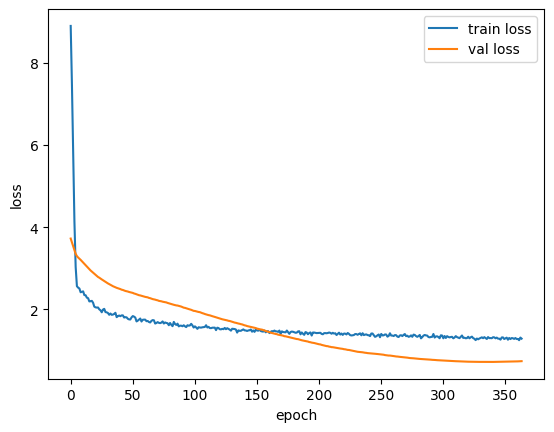

Best validation loss: 0.7197990417480469
epoch for best validation loss: 338


In [20]:
losses = pd.read_csv('losses.csv')
train_losses = losses['train_loss']
val_losses = losses['val_loss']

plt.plot(train_losses, label='train loss')
plt.plot(val_losses, label='val loss')
# set x-axis label
plt.xlabel('epoch')
# set y-axis label
plt.ylabel('loss')
plt.legend()
plt.show()

print("Best validation loss:", best_val_loss)
print("epoch for best validation loss:", np.argmin(val_losses))

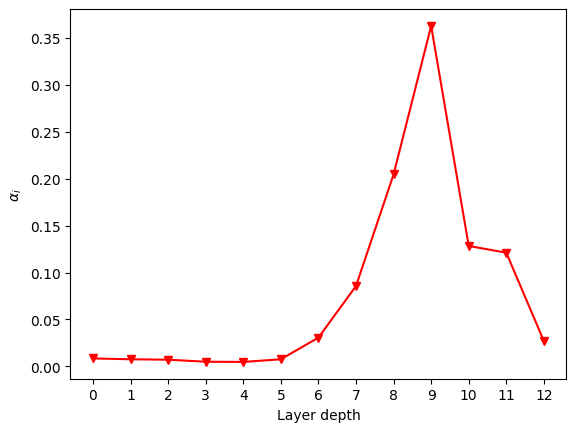

In [21]:
# plot the torch.nn.functional.softmax(dense_mos.weighted_average.weights, dim=0)
# aka the layer number and its importance
softmax_weights = torch.nn.functional.softmax(dense_mos.weighted_average.weights, dim=0).detach().cpu().numpy()

#save the weights to a csv
weights = pd.DataFrame({'softmax_weights': softmax_weights})
weights.to_csv('softmax_weights.csv', index=False)

plt.plot(softmax_weights, marker='v', linestyle='-', color='red', alpha=1, label='Softmax Weights')
plt.xlabel('Layer depth')
plt.xticks(range(13))
# y label is alpha character, the greek letter, with a subindice 
plt.ylabel(r'$\alpha_i$')
plt.show()

# Evaluation and Testing

In [22]:
# Create the testing DataLoader
test_csv_path = "/home/aleph/tesis/classifier/test.csv"
test_dataset = MOSDataset(test_csv_path, split='test')
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False, num_workers=2)

# Load the best model
best_model_path = "/home/aleph/tesis/classifier/DenseMOS_tests/final_model.pth"
dense_mos = DenseMOS(input_dim=768, hidden_dim=128, dropout_prob=0.6, num_layers=13)  # Ensure correct model initialization
dense_mos.to(device)  # Move the model to the device
dense_mos.load_state_dict(torch.load(best_model_path))  # Load the saved models
dense_mos.eval()  # Set model to evaluation mode

# Evaluate the model on the test set
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)  # DataLoader for testing
test_loss = 0.0
outputs_list = []
targets_list = []
with torch.no_grad():  # No gradients needed during evaluation
    for inputs, targets in test_loader:
        inputs = inputs.to(device)  # Move inputs to the GPU
        targets = targets.to(device)  # Move targets to the GPU
        outputs = dense_mos(inputs)  # Forward pass
        outputs_list.append(outputs)
        targets_list.append(targets)
        loss = loss_fn(outputs, targets)  # Calculate loss
        test_loss += loss.item()  # Accumulate the loss

# Average test loss over all batches
avg_test_loss = test_loss / len(test_loader)
print("Test Loss:", avg_test_loss)  # Evaluate the model's performance on the test set

import numpy as np

# Convert targets and outputs to NumPy arrays
targets = np.squeeze(torch.cat(targets_list).cpu().numpy())
outputs = np.squeeze(torch.cat(outputs_list).cpu().numpy())


Test Loss: 0.9915535241365433


In [177]:
# calculate pearson's correlation coefficient and targets_array, compute mae, mse, rmse and r2
# between the predicted MOS scores and the ground truth MOS scores, aka the targets and outputs

from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from scipy.stats import pearsonr

# Calculate Pearson's correlation coefficient
pearson_corr = pearsonr(targets, outputs)
print("Pearson's Correlation Coefficient:", pearson_corr[0])

# Calculate Mean Absolute Error (MAE)
mae = mean_absolute_error(targets, outputs)
print("Mean Absolute Error (MAE):", mae)
rmse = mean_squared_error(targets, outputs, squared=False)
print("Root Mean Squared Error (RMSE):", rmse)
r2 = r2_score(targets, outputs)
print("R^2 Score:", r2)



Pearson's Correlation Coefficient: 0.03537287364385683
Mean Absolute Error (MAE): 0.8567143
Root Mean Squared Error (RMSE): 1.1906047
R^2 Score: -0.9767362805970832


/home/aleph/tesis/.env/lib/python3.12/site-packages/sklearn/metrics/_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


In [23]:
# print target and outputs side by side
for i in range(200):
    print(f"Target: {targets[i]:.2f}, Output: {outputs[i]:.2f}")

Target: 1.50, Output: 1.42
Target: 1.00, Output: 1.40
Target: 1.00, Output: 1.14
Target: 1.00, Output: 1.59
Target: 2.00, Output: 1.30
Target: 2.00, Output: 1.05
Target: 1.00, Output: 1.32
Target: 1.00, Output: 1.27
Target: 2.00, Output: 1.26
Target: 3.00, Output: 1.26
Target: 3.00, Output: 1.18
Target: 1.00, Output: 1.28
Target: 1.00, Output: 1.45
Target: 1.00, Output: 1.23
Target: 3.00, Output: 1.63
Target: 1.00, Output: 1.34
Target: 1.00, Output: 1.48
Target: 1.00, Output: 1.47
Target: 1.50, Output: 1.11
Target: 1.50, Output: 1.15
Target: 1.00, Output: 1.56
Target: 1.50, Output: 1.32
Target: 1.00, Output: 1.32
Target: 3.00, Output: 1.65
Target: 2.00, Output: 1.94
Target: 1.00, Output: 1.30
Target: 1.00, Output: 1.20
Target: 1.00, Output: 1.31
Target: 1.00, Output: 1.28
Target: 3.00, Output: 1.53
Target: 2.00, Output: 1.35
Target: 3.00, Output: 1.58
Target: 2.00, Output: 1.24
Target: 2.00, Output: 1.25
Target: 1.00, Output: 1.34
Target: 2.00, Output: 1.11
Target: 2.00, Output: 1.51
T

### sanity check and experiments

In [84]:
def wav2vec_single_audio(path_to_audio, model_name):
    feature_extractor = Wav2Vec2FeatureExtractor.from_pretrained(model_name)
    model = Wav2Vec2Model.from_pretrained(model_name)
    waveform, sample_rate = librosa.load(path_to_audio, sr=16000)
    inputs = feature_extractor(waveform, return_tensors="pt")
    with torch.no_grad():
        outputs= model(inputs.input_values)
    embeddings = outputs.last_hidden_state
    embeddings = embeddings.mean(dim=1)
    embeddings = embeddings.squeeze().detach().numpy()
                
    return embeddings

def compute_mos(embedding_path):
    best_model_path = "/home/aleph/tesis/classifier/DenseMOS_tests/best_model.pth"
    dense_mos = DenseMOS(input_dim=768, hidden_dim=128, dropout_prob=0.5, num_layers=12)  # Ensure correct model initialization
    dense_mos.to(device)  # Move the model to the device
    dense_mos.load_state_dict(torch.load(best_model_path))  # Load the saved models
    dense_mos.eval()  # Set model to evaluation mode

    #read the embeddings
    embedding = np.load(embedding_path)
    embedding = embedding[1:]
    new_audio_tensor = torch.tensor(embedding, dtype=torch.float32).unsqueeze(0)  # Add batch dimension
    new_audio_tensor = new_audio_tensor.to(device)  # Move to the device

    # Make a prediction using the model
    with torch.no_grad():  # No gradients required for inference
        mos_score = dense_mos(new_audio_tensor)  # Forward pass to get the MOS score
    
    # Output the MOS score
    return mos_score.item()  # Get the scalar value from the tensor

best_model_path = "/home/aleph/tesis/classifier/best_model.pth"
embedding_path = "/home/aleph/tesis/classifier/embeddings/test/B9/VTLP_es-ES-ElviraNeural16.npy"


mos_score = compute_mos(embedding_path)
print("Predicted MOS score:", mos_score)

# compute for csv and save to new column
def compute_mos_for_csv(saved_model_path, path_to_csv, path_to_save_predictions):
    dense_mos = DenseMOS(input_dim=768, hidden_dim=128, dropout_prob=0.5, num_layers=12)  # Ensure model initialization
    dense_mos.load_state_dict(torch.load(best_model_path))  # Load the saved model
    dense_mos.eval()  # Set model to evaluation mode
    model_name = 'facebook/wav2vec2-base-960h'
    metadata_df = pd.read_csv(path_to_csv)
    metadata_df['predicted_mos'] = None
    for index, row in tqdm(metadata_df.iterrows()):
        audio_file = row['stimuli']
        new_audio_embeddings = wav2vec_single_audio(audio_file, model_name)

        # Convert to PyTorch tensor
        new_audio_tensor = torch.tensor(new_audio_embeddings, dtype=torch.float32).unsqueeze(0)  # Add batch dimension

        # Make a prediction using the model
        with torch.no_grad():  # No gradients required for inference
            mos_score = dense_mos(new_audio_tensor)  # Forward pass to get the MOS score
        metadata_df.at[index, 'predicted_mos'] = mos_score.item()
    
        # append to file csv
        metadata_df.to_csv(path_to_save_predictions, index=False)

    return metadata_df

# path_to_csv = "/home/aleph/tesis/classifier/test_set_inference.csv"
# path_to_save_predictions = '/home/aleph/tesis/classifier/test_set_predictions.csv'

# predictions_df = compute_mos_for_csv(best_model_path, path_to_csv, path_to_save_predictions)
# print(predictions_df.head())


Predicted MOS score: 1.3363673686981201
